In [2]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from brainspace.utils.parcellation import map_to_labels, reduce_by_labels
from neuromaps.datasets import fetch_fslr
from surfplot import Plot
from brainspace.datasets import load_parcellation
import plotly.express as px
import os

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
scz_path = 'clean_data/SCZ/schaefer1000'
controls_path = 'clean_data/controls/schaefer1000'

In [4]:
scz_subjects = np.loadtxt('COBRE_SCZ_subjects.txt', dtype = str)
control_subjects = np.loadtxt('COBRE_controls_subjects.txt', dtype = str)

In [6]:
panss = pd.read_csv('COBRE_assessmentData_17938.csv')
len(panss)
panss.replace({'Absent': 1, 'Minimal': 2, 'Mild': 3, 'MD':3, 'Moderate': 4, 'Moderate severe': 5, 'Severe': 6, 'Extreme': 7}, inplace=True)
panss = panss.dropna(subset = ["question_value"])

panss["question_value"] = panss["question_value"].astype(int)

2220

In [7]:
panss_total = pd.DataFrame(columns=['SubjectID', 'PANSS_Total'])

for subject in scz_subjects:

    df_subject = panss[panss['subjectid'] == subject]
    total_score = df_subject['question_value'].sum()
    panss_total = panss_total.append({'SubjectID': subject, 'PANSS_Total': total_score}, ignore_index=True)


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_38402/1408432363.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  panss_total = panss_total.append({'SubjectID': subject, 'PANSS_Total': total_score}, ignore_index=True)
/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_38402/1408432363.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  panss_total = panss_total.append({'SubjectID': subject, 'PANSS_Total': total_score}, ignore_index=True)
/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_38402/1408432363.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  panss_total = panss_total.append({'SubjectID': subject, 'PANSS_Total': total_score}, ignore_index=True)
/var/folders/2m/72fcyjmd7vs3g18rkfwx7

# Pipeline
1. Normalize gradients relative to the neurotypical group gradient.
2. Multiple Linear Regression + LOO-CV
3. Support Vector Regression + LOO-CV

## 1. Gradient Normalization

In [12]:
X_scz_grads = []
for subject in scz_subjects:
    subject_path = f'{scz_path}/sub-{subject}/func'
    grads = np.load(f'{subject_path}/aligned_10grads_{subject}_schaefer1000.npy')
    X_scz_grads.append(grads)
X_scz_grads = np.stack(X_scz_grads)

control_grads = []
for subject in control_subjects:
    subject_path = f'{controls_path}/sub-{subject}/func'
    grads = np.load(f'{subject_path}/aligned_10grads_{subject}_schaefer1000.npy')
    control_grads.append(grads)
control_grads = np.stack(control_grads)

In [17]:
subject_path = f'{scz_path}/sub-{scz_subjects[0]}/func'
scz_grad = np.load(f'{subject_path}/aligned_10grads_{scz_subjects[0]}_schaefer1000.npy')
scz_grad_reshaped = np.expand_dims(scz_grad, axis = 0)
scz_grad_reshaped = scz_grad_reshaped.reshape(scz_grad_reshaped.shape[0], -1)

scaler = StandardScaler()

scaler.fit(control_grads_reshaped)
scz_grad_norm = scaler.transform(scz_grad_reshaped)
scz_grad_norm = scz_grad_norm.reshape(scz_grad.shape)

StandardScaler()

In [22]:
X_scz_grads_norm

array([[[-0.84523195, -0.27444306, -0.72086272, ...,  0.20911677,
          2.03229405, -0.67549056],
        [-0.79926309, -0.6156762 , -0.16280451, ..., -0.07119625,
          0.84011753,  0.12169663],
        [ 1.85845734,  0.18732843,  0.05145732, ..., -1.55216041,
         -0.92913421,  0.78276814],
        ...,
        [ 1.57530374, -0.82849735, -1.25924721, ..., -0.17002987,
         -0.10113301, -1.01539614],
        [ 1.59337632, -0.57799146, -1.37786808, ..., -0.56664555,
         -1.1650898 , -1.08554937],
        [ 1.81376742, -1.04463558, -1.39491614, ..., -0.91132456,
          0.22586077, -1.48236573]],

       [[ 0.76387569,  0.56740769, -0.80911257, ...,  0.53298389,
          0.22116984,  1.2761213 ],
        [-0.21781072, -0.29198339, -1.85505582, ..., -0.05872854,
         -0.22768592,  0.36032944],
        [ 0.70562178, -0.67528394, -0.32146533, ...,  2.42353991,
          0.12814948,  0.88083522],
        ...,
        [ 1.49198378, -0.11086542, -1.10368763, ..., -

In [19]:
scz_grad_norm


array([[-0.84523195, -0.27444306, -0.72086272, ...,  0.20911677,
         2.03229405, -0.67549056],
       [-0.79926309, -0.6156762 , -0.16280451, ..., -0.07119625,
         0.84011753,  0.12169663],
       [ 1.85845734,  0.18732843,  0.05145732, ..., -1.55216041,
        -0.92913421,  0.78276814],
       ...,
       [ 1.57530374, -0.82849735, -1.25924721, ..., -0.17002987,
        -0.10113301, -1.01539614],
       [ 1.59337632, -0.57799146, -1.37786808, ..., -0.56664555,
        -1.1650898 , -1.08554937],
       [ 1.81376742, -1.04463558, -1.39491614, ..., -0.91132456,
         0.22586077, -1.48236573]])

In [10]:
X_scz_grads.shape
control_grads.shape

(73, 1000, 10)

(91, 1000, 10)

In [13]:
control_grads_reshaped = control_grads.reshape(control_grads.shape[0], -1)
X_scz_grads_reshaped = X_scz_grads.reshape(X_scz_grads.shape[0], -1)

In [14]:
control_grads_reshaped.shape
X_scz_grads_reshaped.shape

(91, 10000)

(73, 10000)

In [21]:
scaler = StandardScaler()
scaler.fit(control_grads_reshaped)
X_scz_grads_norm = scaler.transform(X_scz_grads_reshaped)

# reshape normalized patient data back to original shape
X_scz_grads_norm = X_scz_grads_norm.reshape(X_scz_grads.shape)

StandardScaler()

In [6]:
control_group_grads = np.load(os.path.join(controls_path, 'aligned_control_group_10grads_schaefer1000.npy'))

## 2. Muptiple Linear Regression + LOO-CV

In [24]:
import pandas as pd
import itertools
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import LeaveOneOut

# Create a list of gradient combinations to try
grad_combinations = []
for i in range(1, 11):
    grad_combinations += list(itertools.combinations(range(10), i))

# Initialize a DataFrame to store the results
linreg_df = pd.DataFrame(columns=["Num_Gradients", "MSE_Train", "MSE_Test"])

# Loop over the gradient combinations
for num_gradients in range(1, 11):
    for gradient_combo in grad_combinations:
        if len(gradient_combo) != num_gradients:
            continue

        # Select the specified gradients for both control and patient data
        X_scz_grads_norm_sub = X_scz_grads_norm[:, :, list(gradient_combo)]
        y_scz = panss_total['PANSS_Total'].values

        # Initialize the regression model and LOOCV object
        reg = LinearRegression()
        loocv = LeaveOneOut()

        # Initialize lists to store the MSE for each fold
        mse_train = []
        mse_test = []

        # Loop over the LOOCV folds
        for train_idx, test_idx in loocv.split(X_scz_grads_norm_sub):

            # Split the data into training and testing sets
            X_train = X_scz_grads_norm_sub[train_idx]
            y_train = y_scz[train_idx]
            X_test = X_scz_grads_norm_sub[test_idx]
            y_test = y_scz[test_idx]

            # Fit the regression model to the training data
            reg.fit(X_train.reshape(len(train_idx), -1), y_train)

            # Predict the PNASS score for the training and testing data
            y_train_pred = reg.predict(X_train.reshape(len(train_idx), -1))
            y_test_pred = reg.predict(X_test.reshape(1, -1))

            # Calculate the MSE for the training and testing data
            mse_train.append(mean_squared_error(y_train, y_train_pred))
            mse_test.append(mean_squared_error(y_test, y_test_pred))

        # Compute the mean MSE across all folds for both training and testing data
        mean_mse_train = np.mean(mse_train)
        mean_mse_test = np.mean(mse_test)

        # Add the results to the DataFrame
        linreg_df = linreg_df.append(
            {"Num_Gradients": num_gradients, "MSE_Train": mean_mse_train, "MSE_Test": mean_mse_test},
            ignore_index=True
        )

# Print the results
print(linreg_df)


LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_38402/162258970.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  linreg_df = linreg_df.append(


LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_38402/162258970.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  linreg_df = linreg_df.append(


LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_38402/162258970.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  linreg_df = linreg_df.append(


LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_38402/162258970.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  linreg_df = linreg_df.append(


LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_38402/162258970.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  linreg_df = linreg_df.append(


LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_38402/162258970.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  linreg_df = linreg_df.append(


LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

KeyboardInterrupt: 

In [42]:
import csv
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

grad_combinations = np.arange(1, 11)

# Initialize a DataFrame to store the results
linreg_df = pd.DataFrame(columns=["Num_Gradients", "MSE_Train", "MSE_Test", "MAE_Train", "MAE_Test", "R2_Train", "R2_Test", "Obs_Left_Out", "Actual_Score", "Predicted_Score"])

# Loop over the gradient combinations
for n_grads in grad_combinations:
    # Select the specified gradients for both control and patient data
    X_scz_grads_norm_sub = X_scz_grads_norm[:, :, :n_grads]
    y_scz = panss_total['PANSS_Total'].values

    # Initialize the regression model and LOOCV object
    reg = LinearRegression()
    loocv = LeaveOneOut()

    # Initialize lists to store the MSE for each fold
    mse_train = []
    mse_test = []
    mae_train = []
    mae_test = []
    r2_train = []
    r2_test = []
    obs_left_out = []
    actual_scores = []
    predicted_scores = []

    # Loop over the LOOCV folds
    for train_idx, test_idx in loocv.split(X_scz_grads_norm_sub):

        # Split the data into training and testing sets
        X_train = X_scz_grads_norm_sub[train_idx]
        y_train = y_scz[train_idx]
        X_test = X_scz_grads_norm_sub[test_idx]
        y_test = y_scz[test_idx]

        # Fit the regression model to the training data
        reg.fit(X_train.reshape(len(train_idx), -1), y_train)

        # Predict the PNASS score for the training and testing data
        y_train_pred = reg.predict(X_train.reshape(len(train_idx), -1))
        y_test_pred = reg.predict(X_test.reshape(1, -1))

        # Calculate the MSE, MAE, and R^2 for the training and testing data
        mse_train.append(mean_squared_error(y_train, y_train_pred))
        mse_test.append(mean_squared_error(y_test, y_test_pred))
        mae_train.append(mean_absolute_error(y_train, y_train_pred))
        mae_test.append(mean_absolute_error(y_test, y_test_pred))
        r2_train.append(r2_score(y_train, y_train_pred))
        r2_test.append(r2_score(y_test, y_test_pred))
        
        # Append the index of the observation left out and the actual and predicted scores
        obs_left_out.append(test_idx[0])
        actual_scores.append(y_test[0])
        predicted_scores.append(y_test_pred[0])

    # Compute the mean MSE, MAE, and R^2 across all folds for both training and testing data
    mean_mse_train = np.mean(mse_train)
    mean_mse_test = np.mean(mse_test)
    mean_mae_train = np.mean(mae_train)
    mean_mae_test = np.mean(mae_test)
    mean_r2_train = np.mean(r2_train)
    mean_r2_test = np.mean(r2_test)

    filename = 'linreg_loocv_grads_panss_perf.csv'
    # Add the results to the DataFrame
    with open(filename, mode='a') as results_file:
        # Create a CSV writer object
        results_writer = csv.writer(results_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        
        # Write the header row if the file is empty
        if results_file.tell() == 0:
            results_writer.writerow(["Num_Gradients", "MSE_Train", "MSE_Test", "MAE_Train", "MAE_Test", "R2_Train", "R2_Test", "Obs_Left_Out", "Actual_Score", "Predicted_Score"])

        # Write the results for the current train and test session
        for i in range(len(mse_train)):
            results_writer.writerow([n_grads, mse_train[i], mse_test[i], mae_train[i], mae_test[i], r2_train[i], r2_test[i], obs_left_out[i], actual_scores[i], predicted_scores[i]])

LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


112

116

119

113

116

116

117

117

115

117

117

114

117

117

118

116

117

115

116

119

118

116

117

117

114

118

118

116

117

119

114

118

117

118

116

117

117

118

116

116

115

118

117

116

115

117

117

119

118

116

118

114

118

119

116

119

117

118

116

116

117

116

116

119

118

115

117

118

117

118

116

118

115

117

LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


115

116

115

115

117

117

113

117

115

115

116

119

116

117

118

119

118

115

117

117

116

119

118

117

118

117

117

118

118

116

115

120

117

117

119

118

117

118

114

116

117

116

117

117

116

117

118

116

118

119

119

117

116

116

116

116

117

119

117

116

117

116

118

116

115

117

118

118

119

117

118

118

115

LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


114

115

116

117

116

115

112

117

116

115

119

118

117

117

117

117

116

117

115

118

115

115

118

117

118

117

120

118

115

117

116

120

117

118

116

118

117

117

117

118

118

115

117

117

118

117

118

114

117

115

117

118

116

118

118

118

118

118

118

116

118

115

116

116

117

116

117

115

118

112

119

119

116

LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


116

114

116

115

114

117

116

116

116

117

118

118

120

117

117

118

116

121

117

115

116

115

114

113

116

116

114

117

117

117

113

117

118

117

119

119

117

117

118

114

117

117

117

115

115

117

116

115

118

116

115

115

113

116

117

118

119

116

123

116

117

117

117

116

117

118

118

117

115

115

115

116

117

LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


119

116

117

116

116

115

114

114

116

118

115

118

118

116

116

116

116

116

115

116

118

119

115

116

113

116

116

113

118

115

116

117

115

117

118

119

118

117

117

114

116

114

120

116

116

116

118

118

117

115

117

115

114

117

117

117

117

117

117

118

115

116

117

116

115

118

117

116

116

117

116

117

116

LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


116

117

115

116

115

114

115

116

117

118

115

115

120

115

117

119

118

115

116

118

116

114

117

115

116

119

117

117

118

116

118

116

118

117

116

116

114

118

119

115

115

117

119

115

114

116

116

117

118

115

115

118

116

116

117

116

115

117

118

115

116

116

118

115

117

116

117

118

115

117

116

118

116

LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


116

116

117

116

116

116

117

118

116

116

118

118

118

116

117

116

116

117

115

118

117

119

116

115

114

116

119

116

116

114

118

115

116

118

116

118

116

116

116

116

115

117

115

117

117

118

118

118

117

117

115

118

115

119

118

119

118

111

118

119

117

115

116

118

117

116

118

115

118

116

116

114

117

LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


119

116

117

117

115

117

115

116

117

116

116

119

117

117

115

114

115

117

116

118

117

116

114

115

115

116

118

114

117

114

117

114

115

120

116

117

116

115

116

114

118

117

117

118

116

117

115

114

116

116

114

117

118

118

116

116

115

115

117

116

118

114

119

117

118

116

119

115

117

116

119

117

116

LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


116

115

117

116

116

114

116

116

117

116

116

116

117

117

114

116

117

115

119

116

117

119

114

114

116

116

117

114

117

117

118

116

116

118

115

117

114

115

117

116

115

117

117

116

111

117

118

116

117

118

117

117

116

118

118

114

114

117

117

118

115

116

116

117

118

117

117

116

117

117

119

116

117

LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression()

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


114

116

118

115

117

116

115

119

114

116

117

118

119

114

118

116

118

116

119

116

115

113

118

117

119

119

117

118

117

117

115

117

117

118

118

117

117

118

117

115

117

120

117

118

117

117

117

120

117

117

117

116

117

118

117

118

115

119

121

118

117

117

117

116

116

117

118

117

118

119

118

116

119

In [43]:
lingreg_loocv_grads_panss_results = pd.read_csv('linreg_loocv_grads_panss_perf.csv')

In [47]:
lingreg_loocv_grads_panss_results

Num_Gradients     MSE_Train    MSE_Test     MAE_Train   MAE_Test  \
0                1  1.710250e-27  274.827516  3.128362e-14  16.577923   
1                1  1.209587e-27  280.294440  2.773090e-14  16.741996   
2                1  1.821042e-27  206.705669  3.404684e-14  14.377262   
3                1  1.628910e-27  396.602235  3.286260e-14  19.914875   
4                1  1.284616e-27  116.633418  2.881646e-14  10.799695   
..             ...           ...         ...           ...        ...   
725             10  3.469586e-27  432.565860  4.539579e-14  20.798218   
726             10  8.625580e-27  463.435458  6.306067e-14  21.527551   
727             10  5.721170e-27  752.057243  5.023142e-14  27.423662   
728             10  6.108238e-27  271.584932  6.187643e-14  16.479834   
729             10  6.407654e-27   49.243658  5.960664e-14   7.017383   

     R2_Train  R2_Test  Obs_Left_Out  Actual_Score  Predicted_Score  
0         1.0      NaN             0            57        40.422077  
1         1.0      NaN             1            47        63.741996  
2         1.0      NaN             2            47        61.377262  
3         1.0      NaN             3            41        60.914875  
4         1.0      NaN             4            39        49.799695  
..        ...      ...           ...           ...              ...  
725       1.0      NaN            68            36        56.798218  
726       1.0      NaN            69            40        61.527551  
727       1.0      NaN            70            83        55.576338  
728       1.0      NaN            71            70        53.520166  
729       1.0      NaN            72            55        62.017383  

[730 rows x 10 columns]

In [48]:
lingreg_loocv_grads_panss_results["Rel_Error"] = lingreg_loocv_grads_panss_results["MAE_Test"]/lingreg_loocv_grads_panss_results["Predicted_Score"]

Text(0.5, 0, 'Number of Gradients')

Text(0, 0.5, 'Mean Relative Error')

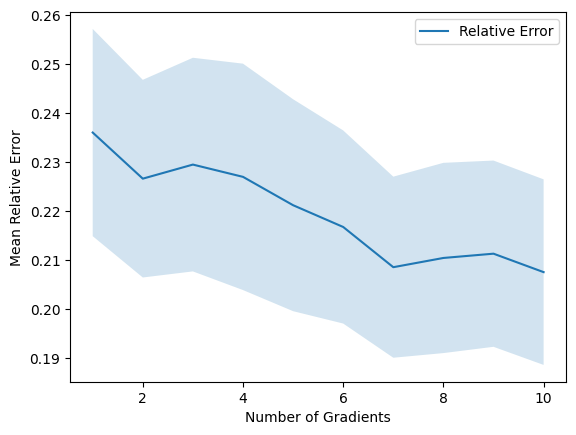

In [50]:
# Compute the mean and standard error of the mean for each number of gradients
mean_test = lingreg_loocv_grads_panss_results.groupby("Num_Gradients")["Rel_Error"].mean()
sem_test = lingreg_loocv_grads_panss_results.groupby("Num_Gradients")["Rel_Error"].sem()

# Plot the means and standard errors
fig, ax = plt.subplots()

ax.plot(mean_test.index, mean_test, label="Relative Error")
ax.fill_between(mean_test.index, mean_test - sem_test, mean_test + sem_test, alpha=0.2)
ax.legend()
ax.set_xlabel("Number of Gradients")
ax.set_ylabel("Mean Relative Error")
plt.show()

Text(0.5, 0, 'Number of Gradients')

Text(0, 0.5, 'Mean Abs Error')

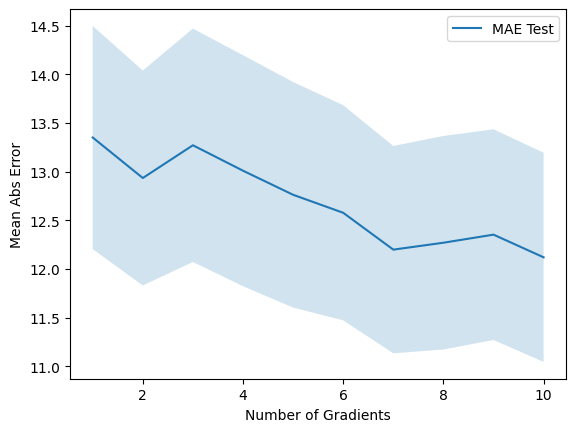

In [46]:
# Compute the mean and standard error of the mean for each number of gradients
mean_test = lingreg_loocv_grads_panss_results.groupby("Num_Gradients")["MAE_Test"].mean()
sem_test = lingreg_loocv_grads_panss_results.groupby("Num_Gradients")["MAE_Test"].sem()

# Plot the means and standard errors
fig, ax = plt.subplots()

ax.plot(mean_test.index, mean_test, label="MAE Test")
ax.fill_between(mean_test.index, mean_test - sem_test, mean_test + sem_test, alpha=0.2)
ax.legend()
ax.set_xlabel("Number of Gradients")
ax.set_ylabel("Mean Abs Error")
plt.show()

Text(0.5, 0, 'Number of Gradients')

Text(0, 0.5, 'Mean Abs Error')

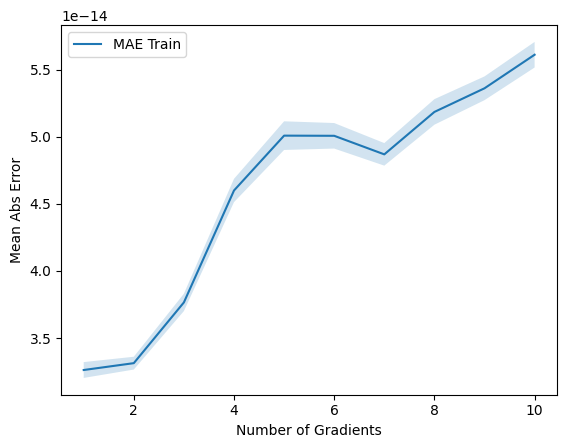

In [45]:
import matplotlib.pyplot as plt

# Compute the mean and standard error of the mean for each number of gradients
mean_train = lingreg_loocv_grads_panss_results.groupby("Num_Gradients")["MAE_Train"].mean()
sem_train = lingreg_loocv_grads_panss_results.groupby("Num_Gradients")["MAE_Train"].sem()
#mean_test = lingreg_loocv_grads_panss_results.groupby("Num_Gradients")["MAE_Test"].mean()
#sem_test = lingreg_loocv_grads_panss_results.groupby("Num_Gradients")["MAE_Test"].sem()

# Plot the means and standard errors
fig, ax = plt.subplots()
ax.plot(mean_train.index, mean_train, label="MAE Train")
ax.fill_between(mean_train.index, mean_train - sem_train, mean_train + sem_train, alpha=0.2)
#ax.plot(mean_test.index, mean_test, label="MAE Test")
#ax.fill_between(mean_test.index, mean_test - sem_test, mean_test + sem_test, alpha=0.2)
ax.legend()
ax.set_xlabel("Number of Gradients")
ax.set_ylabel("Mean Abs Error")
plt.show()
